# DCGAN trained on MNIST

- Imports.
- Set some hyperparameters (`latent_dim` of input noise, `image_size` etc.)
- `Generator` class. Start with a noise vector of size `latent_dim`. Put the vector through a linear layer, reshape (using `einops` `rearrange`), put through a few 2d convolutions, batch norms, leaky relus, and upsample a few times. Finally, put through a tanh to get a single-channel image of size `(image_size, image_size)`, with all values between -1 and 1.
- `DiscriminatorModule` class. 2d convolution with `stride=2` to reduce height and width, leaky relu, dropout, and batch norm.
- `Discriminator` class. 4 discriminator modules, increasing number of channels and decreasing height and width. After that, flatten and put through a linear layer to output a single number. Put through sigmoid so that we can intepret the number as a probability.
- Dataset and dataloader. Normalize images to have values between -1 and 1.
- Instantiate the generator and the discriminator. Define the loss function (`BCELoss`). Define the optimizer for the generator and the optimizer for the discriminator.
- Train the DCGAN (just for a single epoch). At each training step, train the discriminator first, then the generator. The discriminator loss is the sum of the loss on the real MNIST images (with label 1) and the loss on a batch of fake images generated by the generator (with label 0). The generator loss is the loss on a batch of fake images generated by the generator but labelled as real images.
- Display images generated by the generator after 0 training steps, 400 training steps, and 1875 training steps (1 epoch).

### Imports

In [39]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

from einops import rearrange

from IPython.display import Image

### Hyperparameters etc.

In [40]:
latent_dim = 64
image_size = 64
batch_size = 32
learning_rate = 1e-3

logging_interval = 200

### Generator

Note that the generated image has 1 channel, not 3.

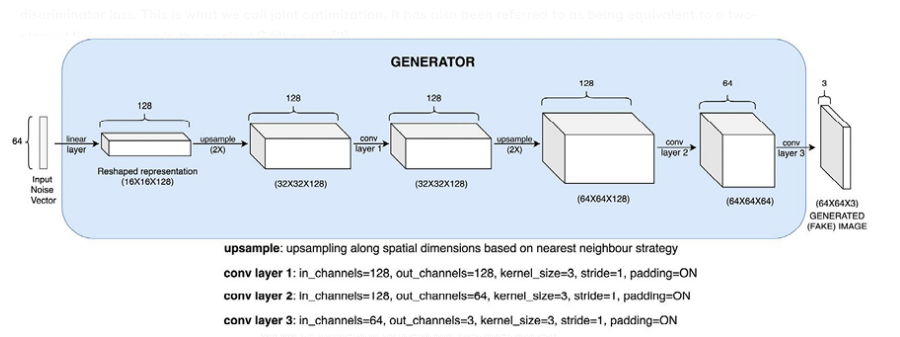

In [41]:
Image('images/dcgan-generator.png')

In [42]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_size = image_size // 4
        self.linear = nn.Linear(latent_dim, 128 * self.input_size ** 2)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(64, 1, 3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = rearrange(x, 'b (c h w) -> b c h w', 
                c=128, h=self.input_size, w=self.input_size)
        x = self.batch_norm1(x)
        x = self.upsample1(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu1(x)
        x = self.upsample2(x)
        x = self.conv2(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        return x

### Discriminator

Note that the input image has 1 channel, not 3.

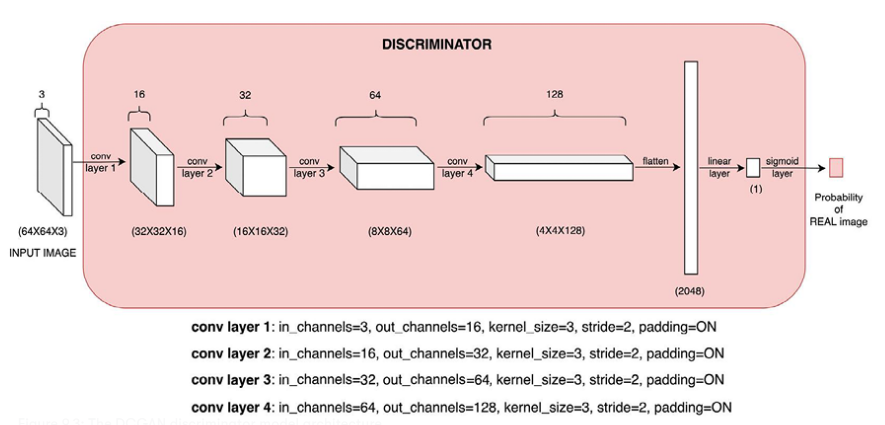

In [43]:
Image('images/dcgan-discriminator.png')

In [44]:
class DiscriminatorModule(nn.Module):

    def __init__(self, in_channels, out_channels, do_batch_norm=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout2d(0.25)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.do_batch_norm = do_batch_norm 

    def forward(self, x):
        x = self.conv(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        if self.do_batch_norm:
            x = self.batch_norm(x)
        return x    

In [45]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.discriminator_modules = nn.Sequential(
            DiscriminatorModule(1, 16, do_batch_norm=False),
            DiscriminatorModule(16, 32),
            DiscriminatorModule(32, 64),
            DiscriminatorModule(64, 128)
        )
        self.linear = nn.Linear(128 * 4 * 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):     
        x = self.discriminator_modules(x)
        x = rearrange(x, 'b c h w -> b (c h w)')
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

### Dataset and dataloader

In [46]:
dataset = datasets.MNIST('/data', train=True, download=True, 
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Instantiate generator and discriminator; define loss function and optimizers

In [47]:
gen = Generator()
disc = Discriminator()  
loss_fn = nn.BCELoss()

optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

### Train DCGAN

In [48]:
epochs = 1

for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):

        batch_size = images.shape[0]
        real_images = images
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train discriminator
        optimizer_disc.zero_grad()
        real_loss = loss_fn(disc(real_images), real_labels)

        noise = torch.randn(batch_size, latent_dim)
        fake_images = gen(noise)
        fake_loss = loss_fn(disc(fake_images), fake_labels)

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        # Train generator
        optimizer_gen.zero_grad()

        noise = torch.randn(batch_size, latent_dim)
        fake_images = gen(noise)
        gen_loss = loss_fn(disc(fake_images), real_labels)
        gen_loss.backward()
        optimizer_gen.step()

        if idx % logging_interval == 0:
            print(f'Epoch [{epoch}/{epochs}], Step [{idx}/{len(dataloader)}], disc_loss: {disc_loss.item()}, gen_loss: {gen_loss.item()}')
            save_image(fake_images.data[:25], f'images/gen_mnist_{epoch}_{idx}.png', nrow=5, normalize=True)

Epoch [0/1], Step [0/1875], disc_loss: 1.3598778247833252, gen_loss: 0.7989857196807861
Epoch [0/1], Step [200/1875], disc_loss: 1.337843894958496, gen_loss: 0.6743948459625244
Epoch [0/1], Step [400/1875], disc_loss: 0.9786993265151978, gen_loss: 1.343408465385437
Epoch [0/1], Step [600/1875], disc_loss: 1.469996690750122, gen_loss: 0.7930101156234741
Epoch [0/1], Step [800/1875], disc_loss: 0.950070858001709, gen_loss: 1.6359063386917114
Epoch [0/1], Step [1000/1875], disc_loss: 0.842577338218689, gen_loss: 1.4072227478027344
Epoch [0/1], Step [1200/1875], disc_loss: 2.2608046531677246, gen_loss: 2.826667547225952
Epoch [0/1], Step [1400/1875], disc_loss: 1.0807011127471924, gen_loss: 0.8096288442611694
Epoch [0/1], Step [1600/1875], disc_loss: 0.5228681564331055, gen_loss: 0.7389643788337708
Epoch [0/1], Step [1800/1875], disc_loss: 1.9779027700424194, gen_loss: 4.843109130859375


In [50]:
save_image(fake_images.data[:25], f'images/gen_mnist_final.png', nrow=5, normalize=True)

### Images generated by the generator after 0 training steps

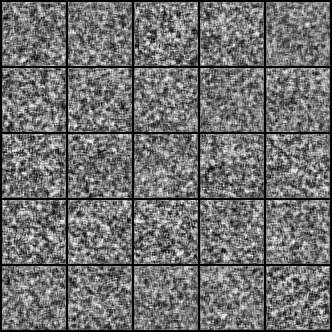

In [52]:
Image('images/gen_mnist_0_0.png')

### Images generated by the generator after 400 training steps

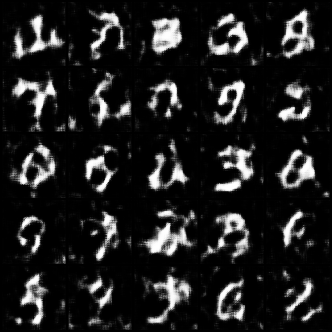

In [53]:
Image('images/gen_mnist_0_400.png')

### Images generated by the generator after 1 epoch (1875 training steps)

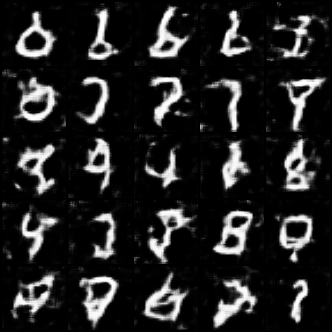

In [51]:
Image('images/gen_mnist_final.png')